In [5]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [6]:
# Data Load
df_train = pd.read_csv('train.csv').dropna()
df_train.head(1)
df_train.columns = ['id', 'hour', 'temp', 'precip',
       'windspeed', 'humidity', 'visibility',
       'ozone', 'pm10', 'pm2_5', 'count']
print(df_train.head(1))
print(len(df_train))

   id  hour  temp  precip  windspeed  ...  visibility  ozone  pm10  pm2_5  count
0   3    20  16.3     1.0        1.5  ...       576.0  0.027  76.0   33.0   49.0

[1 rows x 11 columns]
1328


In [7]:
# Model split
from sklearn.model_selection import train_test_split

X, y = df_train.iloc[:,1:-1], df_train.iloc[:,-1]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=37)
print(len(X_train))

929


In [8]:
# Dummy, const treatment
X_train = pd.get_dummies(X_train, columns=['precip'], drop_first = True)
X_train = sm.add_constant(X_train)
X_val = pd.get_dummies(X_val, columns=['precip'], drop_first = True)
X_val = sm.add_constant(X_val)

In [10]:
# fit_regularized 
ols_lasso = sm.OLS(y_train, X_train).fit_regularized(method="elastic_net", alpha = 0.1, L1_wt=1)
ols_ridge = sm.OLS(y_train, X_train).fit_regularized(method="elastic_net", alpha = 0.1, L1_wt=0)
ols_elnet = sm.OLS(y_train, X_train).fit_regularized(method="elastic_net", alpha = 0.1, L1_wt=0.5)

In [41]:
ols_lasso.params.index == X_train.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [45]:
# changing alpha - ridge
alpha = np.logspace(-3,1,5) # range of alpha(exponential)
data = []
for i, a in enumerate(alpha): 
    ridge = sm.OLS(y_train, X_train).fit_regularized(method = 'elastic_net', L1_wt = 0, alpha = a)
    data.append(ridge.params)
df_ridge = pd.DataFrame(data, index = alpha).T.round(3)
df_ridge.index = X_train.columns
print(df_ridge)

,0.001,0.010,0.100,1.000,10.000
const,-47.021,-19.137,-2.610,-0.172,0.031
hour,4.570,4.542,4.497,4.631,4.393
temp,5.831,5.658,5.558,5.548,4.641
windspeed,8.344,8.056,7.287,4.580,1.369
humidity,-0.242,-0.424,-0.561,-0.597,-0.591
visibility,0.008,0.002,0.000,0.002,0.013
ozone,52.863,6.231,0.684,0.095,0.020
pm10,-0.331,-0.368,-0.381,-0.356,-0.281
pm2_5,0.165,0.067,0.011,0.009,0.174
precip_1.0,-59.797,-42.783,-11.126,-1.313,-0.127


In [46]:
# For lasso and elnet
alpha = np.logspace(-3,1,5) # range of alpha(exponential)
data = []
for i, a in enumerate(alpha): 
    lasso = sm.OLS(y_train, X_train).fit_regularized(method = 'elastic_net', L1_wt = 1, alpha = a)
    data.append(lasso.params)
df_lasso = pd.DataFrame(data, index = alpha).T.round(3)
df_lasso.index = X_train.columns

alpha = np.logspace(-3,1,5) # range of alpha(exponential)
data = []
for i, a in enumerate(alpha): 
    elnet = sm.OLS(y_train, X_train).fit_regularized(method = 'elastic_net', L1_wt = 0.5, alpha = a)
    data.append(elnet.params)
df_elnet = pd.DataFrame(data, index = alpha).T.round(3)
df_elnet.index = X_train.columns

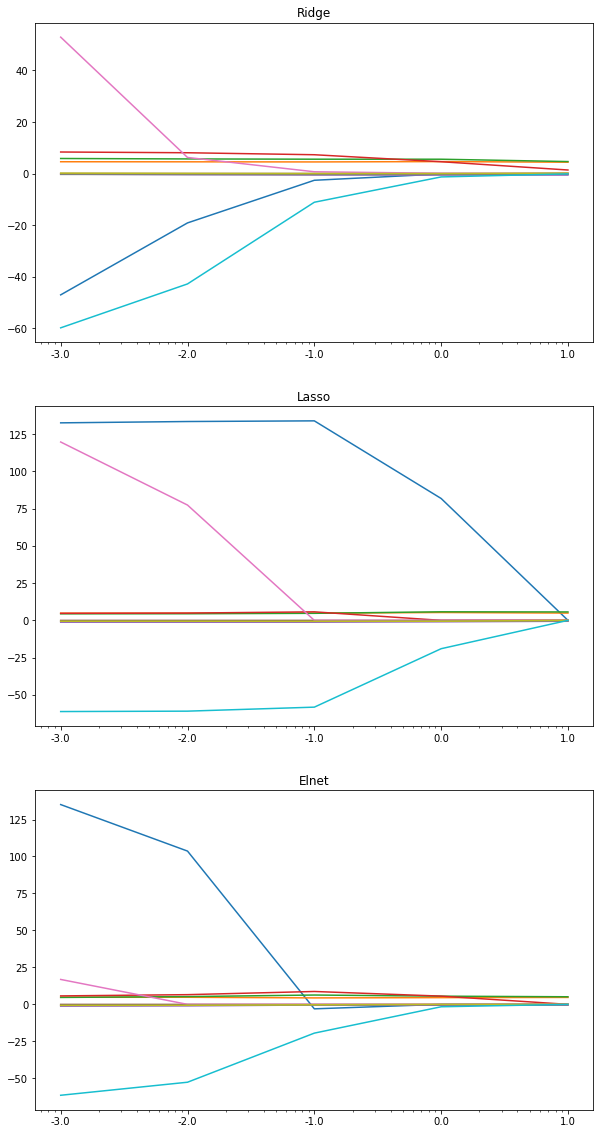

In [52]:
# Plot : coef vs. alpha
fig = plt.figure(figsize = (10,20))
ax1 = plt.subplot(3,1,1)
plt.semilogx(df_ridge.T) # ridge
plt.xticks(np.logspace(-3,1,5), labels=np.log10(alpha))
plt.title('Ridge')

ax2 = plt.subplot(3,1,2)
plt.semilogx(df_lasso.T) # lasso
plt.xticks(np.logspace(-3,1,5), labels=np.log10(alpha))
plt.title('Lasso')

ax3 = plt.subplot(3,1,3)
plt.semilogx(df_elnet.T) # elnet
plt.xticks(np.logspace(-3,1,5), labels=np.log10(alpha))
plt.title('Elnet')
plt.savefig('plots/coef_vs_alpha.png', transparent = False, facecolor = 'white')

In [72]:
# Tune alpha with validation
from sklearn.metrics import mean_squared_error
def tune_alpha(y, X, y_val, X_val, wt_list):
    alpha = np.logspace(-3,1,5) # 10^-3 to 10^1 by sqrt(10)
    data = []
    for wt in wt_list:
        data_wt = []
        for i, a in enumerate(alpha):
            model = sm.OLS(y, X).fit_regularized(method='elastic_net', alpha = a, L1_wt=wt)
            pred = model.predict(X_val)
            rmse = np.sqrt(mean_squared_error(y_val, pred)).round(3)
            data_wt.append(rmse)
        data.append(data_wt)
    df = pd.DataFrame(data, index=wt_list)
    df.columns = alpha
    return df

tune_alpha(y_train, X_train, y_val, X_val, wt_list=[1, 0.5, 0]) # lasso to ridge

,0.001,0.010,0.100,1.000,10.000
1.0,53.806,53.830,54.141,53.682,53.168
0.5,54.171,54.114,54.388,53.496,53.287
0.0,53.244,53.110,53.496,53.349,53.480


In [93]:
# Tune alpha with validation(fixed L1_wt with alpha_ls)
from sklearn.metrics import mean_squared_error
def tune_alpha(y, X, y_val, X_val, alpha_ls):
    wt_list = [1, 0.5, 0]
    data = []
    for wt in wt_list:
        data_wt = []
        for i, a in enumerate(alpha_ls):
            model = sm.OLS(y, X).fit_regularized(method='elastic_net', alpha = a, L1_wt=wt)
            pred = model.predict(X_val)
            rmse = np.sqrt(mean_squared_error(y_val, pred)).round(3)
            data_wt.append(rmse)
        data.append(data_wt)
    df = pd.DataFrame(data, index=wt_list).T
    df.index = alpha_ls
    return df

,1.0,0.5,0.0
0.000100,53.804,53.910,53.237
0.000316,53.805,54.044,53.251
0.001000,53.806,54.171,53.244
0.003162,53.811,54.185,53.169
0.010000,53.830,54.114,53.110
0.031623,53.951,54.211,53.253
0.100000,54.141,54.388,53.496
0.316228,53.583,53.858,53.533
1.000000,53.682,53.496,53.349
3.162278,54.051,53.175,53.184


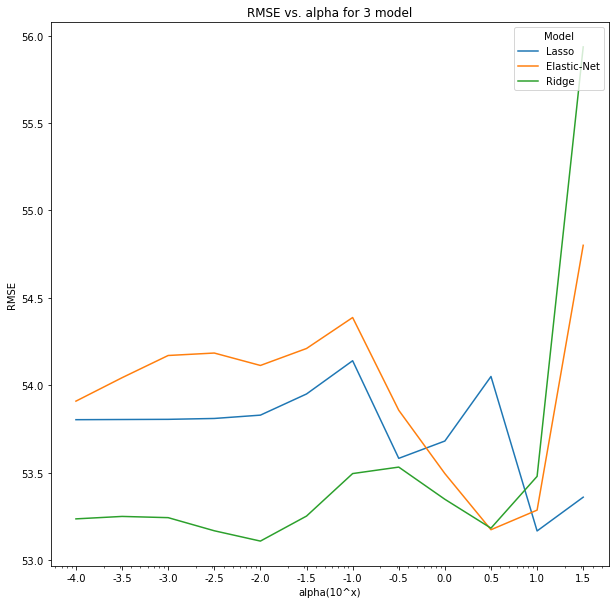

In [102]:
# Tune alpha plot
alpha_ls = np.power(10,(np.arange(-4, 2, 0.5))) # 10 grid of alpha
df = tune_alpha(y_train, X_train, y_val, X_val, alpha_ls=alpha_ls)

fig = plt.figure(figsize=(10,10))
plt.semilogx(df, label=['Lasso','Elastic-Net','Ridge'])
plt.legend(loc='upper right', title = 'Model')
plt.xticks(alpha_ls, labels=np.log10(alpha_ls))
plt.ylabel('RMSE')
plt.xlabel('alpha(10^x)')
plt.title('RMSE vs. alpha for 3 model')
plt.savefig('plots/rmse_vs_alpha.png', facecolor='white', transparent=False)

In [126]:
# LARS
from sklearn import linear_model
reg = linear_model.Lars(n_nonzero_coefs=5, fit_intercept=True, normalize=False)
reg.fit(X_train, y_train)
pred_val = reg.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, pred_val)).round(3)
print(rmse)

53.242


In [131]:
# Checking path of Lars Algorithm
pd.DataFrame(reg.coef_path_, index = X_train.columns).round(3)

,0,1,2,3,4,5
const,0.0,0.000,0.000,0.000,0.000,0.000
hour,0.0,0.000,0.000,1.771,2.639,4.904
temp,0.0,0.000,0.000,0.000,0.000,5.799
windspeed,0.0,0.000,0.000,0.000,0.000,0.000
humidity,0.0,0.000,-0.579,-0.694,-0.834,-0.516
visibility,0.0,0.045,0.034,0.028,0.021,0.008
ozone,0.0,0.000,0.000,0.000,0.000,0.000
pm10,0.0,0.000,0.000,0.000,-0.095,-0.270
pm2_5,0.0,0.000,0.000,0.000,0.000,0.000
precip_1.0,0.0,0.000,0.000,0.000,0.000,0.000
